# Keras Based Models
**Authors**: Vilhelm Stiernstedt, Sharon Marín Salazar & Andrea Tondella
<br>
**Date**: 26/05/2018

In this section we will conver more advanced modelling including other approaches to text processing. We wil try to use embeddning with word2vec. The main focus will be to try out different nueral networks rather than trying to acheieve the optimal accuracy. Hopefully one our models will be sufficently good and thus we can use this for our ensamble/stacking in the last section. Models to be covered:
1. Simple Sequential
    - tokenizer
    - count_vectorizer
    - tf-idf_vectorizer
2. CNN
3. LSTM
    - Using Embedding
        - simple LSTM
        - LSTM w. CNN
    - word2vec w. gloVe 50b dataset
    
#### Text Processing 
Rather than importing our cleaned data from the first section we will import the raw data and dismiss all misalinged data. Further, we will combine title and text to allow our networks to make its own conclusion with the most available information.


In [1]:
# import libraries
# general libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import os
import urllib
from urllib.request import urlretrieve
from os import mkdir, makedirs, remove, listdir
from collections import Counter

# keras libs
from keras.wrappers.scikit_learn import KerasClassifier
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding, Reshape, BatchNormalization
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM

# sklearn libs
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics as skMetric

# fix random seed for reproducibility
np.random.seed(42)

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Import Data

In [3]:
# set path
wd = '/Users/Mille/GDriveMBD/Term3/NLP/Assignment_1/git-nlp-fake-news/'

# import data
df_train = pd.read_csv(wd + '/data/fake_or_real_news_training.csv')
df_test = pd.read_csv(wd + '/data/fake_or_real_news_test.csv')

In [4]:
# inspect df_train
df_train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [5]:
# drop rows where X1 & X2 != NaN
df_train = df_train[(df_train.X1.isnull()) & (df_train.X2.isnull())]

In [6]:
# drop useless features -> X1 & X2
df_train.drop(['X1', 'X2'], axis=1, inplace=True)

In [7]:
# inspect df_train
df_train.head()

,ID,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [8]:
# combine data
df_all = df_train.append(df_test)

/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


### Data Processing

#### Features Engineering
- Concatenate title and text.

#### Text Cleaning -> Not used ATM
Clean title and text by preforming the following operations:
1. Convert to lower case
2. Remove Urls
3. Remove everything but characters and punctuation
4. Replace mulitple periods with a single one
5. Replace periods with a single one
6. Replace multple white space with a single one

#### Preprocessing
1. Split data to back to test and train
2. Define text and label
3. LabelEncoder to transform labels to integers:
    - FAKE = 0
    - REAL = 1


#### Merge title and text

In [9]:
# merge text and title
df_all['combined'] = df_all.title + ' ' + df_all.text

In [9]:
# view 
df_all.combined.head()

0    You Can Smell Hillary’s Fear Daniel Greenfield...
1    Watch The Exact Moment Paul Ryan Committed Pol...
2    Kerry to go to Paris in gesture of sympathy U....
3    Bernie supporters on Twitter erupt in anger ag...
4    The Battle of New York: Why This Primary Matte...
Name: combined, dtype: object

#### Cleaning Text

In [10]:
# clean text & title for df_all ->
#df_all.title = df_all.title.str.lower() # lower case
#df_all.text = df_all.text.str.lower() # lower case
#df_all.title = df_all.title.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
#df_all.text = df_all.text.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
#df_all.title = df_all.title.str.replace(r'[^\.\w\s]','') # remove everything but characters and punctuation
#df_all.text = df_all.text.str.replace(r'[^\.\w\s]','') # remove everything but characters and punctuation
#df_all.title = df_all.title.str.replace(r'\.\.+','.') # replace multple periods with a single one
#df_all.text = df_all.text.str.replace(r'\.\.+','.') # replace multiple periods with a single one
#df_all.title = df_all.title.str.replace(r'\.',' . ') # replace periods with a single one
#df_all.text = df_all.text.str.replace(r'\.',' . ') # replace multiple periods with a single one
#df_all.title = df_all.title.str.replace(r'\s\s+',' ') # replace multiple white space with a single one
#df_all.text = df_all.text.str.replace(r'\s\s+',' ') # replace multiple white space with a single one
#df_all.title = df_all.title.str.strip() # strip white space
#df_all.text = df_all.text.str.strip() # strip white space

In [11]:
# view changes
df_all.head()

,ID,label,text,title,combined
0,8476,FAKE,"Daniel Greenfield, a Shillman Journalism Fello...",You Can Smell Hillary’s Fear,You Can Smell Hillary’s Fear Daniel Greenfield...
1,10294,FAKE,Google Pinterest Digg Linkedin Reddit Stumbleu...,Watch The Exact Moment Paul Ryan Committed Pol...,Watch The Exact Moment Paul Ryan Committed Pol...
2,3608,REAL,U.S. Secretary of State John F. Kerry said Mon...,Kerry to go to Paris in gesture of sympathy,Kerry to go to Paris in gesture of sympathy U....
3,10142,FAKE,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",Bernie supporters on Twitter erupt in anger ag...,Bernie supporters on Twitter erupt in anger ag...
4,875,REAL,It's primary day in New York and front-runners...,The Battle of New York: Why This Primary Matters,The Battle of New York: Why This Primary Matte...


#### Model Preprocessing

In [10]:
# split data again
train = df_all[:len(df_train)]
test = df_all[len(df_train):]

# subset text & label
text = train.combined
label = train.label

# define labelencoder and preprocess label
le = LabelEncoder()
label = le.fit_transform(label)

### Text Preprocessing for Simple Sequential Model
- Bag of Words - Vectorizing texts trying:
    - Tokenizer (count, freq, tf-idf)
    - CountVectorier
    - tf-idf (Sklearn)
    - one-hot encoding (combined text and title) -> not working atm
- Parameters to try:
    - ngrams
    - max_features / num_words (words used)

#### Tokenizer

In [14]:
# Mehtod 1 
# define maxium features -> arbitary
num_max = 5000

# define tokenziner
tok = Tokenizer(num_words=num_max, lower=True)
# tokenize
tok.fit_on_texts(text)
# encode document (alter between mode; count, tfidf)
mat_text = tok.texts_to_matrix(text, mode='count')

# preview process
print(label[:5])
print(mat_text[:5])
print(label.shape, mat_text.shape)

[0 0 1 0 1]
[[ 0. 93. 34. ...  0.  0.  0.]
 [ 0. 16. 14. ...  0.  0.  0.]
 [ 0. 24. 15. ...  0.  0.  0.]
 [ 0. 25. 14. ...  0.  0.  0.]
 [ 0. 19. 13. ...  0.  0.  0.]]
(3966,) (3966, 5000)


#### CountVectorizer

In [192]:
# Method 2 
# define maxium features
num_max = 5000

# define count vectorizer
count_vectorizer = CountVectorizer(max_features=num_max) #, ngram_range=(1,3)) # parameters to change ngrams
# tokenize 
count_vectorizer.fit(text)
# encode document
count_vector = count_vectorizer.transform(text)

# preview process
print(label[:5])
print(mat_text[:5])
print(label.shape, count_vector.shape)

[0 0 1 0 1]
[[ 0. 93. 34. ...  0.  0.  0.]
 [ 0. 17. 14. ...  0.  0.  0.]
 [ 0. 24. 17. ...  0.  0.  0.]
 [ 0. 26. 15. ...  0.  0.  0.]
 [ 0. 20. 13. ...  0.  0.  0.]]
(3966,) (3966, 5000)


#### TF-IDF Vectorizer

In [193]:
# Method 3
# define maxium features
num_max = 5000

# tf-idf (Term Frequency times inverse document frequency)
tfidf_vectorizer = TfidfVectorizer(max_features=num_max) #, ngram_range=(1,3)) # parameters to change ngrams
# tokenize and build vocab 
tfidf_vectorizer.fit(text)
# encode document
tfidf_vector = tfidf_vectorizer.transform(text)

# preview process
print(label[:5])
print(mat_text[:5])
print(label.shape, tfidf_vector.shape)

[0 0 1 0 1]
[[ 0. 93. 34. ...  0.  0.  0.]
 [ 0. 17. 14. ...  0.  0.  0.]
 [ 0. 24. 17. ...  0.  0.  0.]
 [ 0. 26. 15. ...  0.  0.  0.]
 [ 0. 20. 13. ...  0.  0.  0.]]
(3966,) (3966, 5000)


#### One-hot Encoding

In [194]:
# Method 4 -> one-hot encoding 
# text_to_word_sequence doesn't allow for pd series input. no solution find as of now. method put on hold.
# import libs
#from keras.preprocessing.text import one_hot
#from keras.preprocessing.text import text_to_word_sequence

# define maxium features
#num_max = 5000

# estimate the size of the vocabulary
#words = text_to_word_sequence(text, split=' ', lower=False)
#vocab_size = len(words)

# integer encode the document
#onehot_encode = one_hot(text, round(vocab_size*1.3))

# preview process
#print(label[:5])
#print(one_hot_text[:5])
#print(label.shape, one_hot_text.shape)

#### split -> training / validation

In [17]:
# split data into training (80%) and test/validation (20%)
x_train, x_test, y_train, y_test = train_test_split(mat_text, label,
                                                    test_size=0.2, random_state=42)

#### Sequential Model 
1. Define Sequential model function:
    - First layer 512 neurons with an 'relu' activation
    - Second layer 256 neurons with an 'relu' activation
    - Loss function: 'binary_crossentropy'
    - Metric: Accuracy
<br>
<br>
2. Define model pipeline that holds range of model inputs:
    - batch size 
    - optimizers
    - epochs
    - kernel intitializers
3. Use random serach grid to test all paramters
4. Evaluate model results

In [18]:
# define sequential model
def create_simple_model(optimizer='adam', init='glorot_uniform', dropout_rate=0.2):
    model = Sequential()
    # first layer
    model.add(Dense(512,
                    activation='relu',
                    input_shape=(num_max,),
                    kernel_initializer=init)
             ) 
    model.add(Dropout(dropout_rate)) # dropout
    # second layer
    model.add(Dense(256,
                    activation='relu'
                    ,kernel_initializer=init)
             )
    model.add(Dropout(dropout_rate)) # dropout 
    # out_layer
    model.add(Dense(1,
                    activation='sigmoid',
                    kernel_initializer=init)
             )
    # summary
    model.summary()
    # compiler
    model.compile(loss='binary_crossentropy',  # loss function
              optimizer=optimizer, # optimizer
              metrics=['acc', metrics.abinary_accuracy]) # metric 
    print('compile done')
    return model

#### Pipeline

In [21]:
# create model
seq_m = KerasClassifier(build_fn=create_simple_model,
                        verbose=0)

# specify random grid search paramters 
optimizers = ['adam']
epochs = [5]
batch_size = [32]
init = ['glorot_uniform'] # , 'normal', 'uniform']
dropout_rate = [0.75] 

# add paramters into dict
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batch_size,
                  init=init, dropout_rate=dropout_rate)

# specify randsearch gird
seq_m_grid = GridSearchCV(estimator=seq_m, param_grid=param_grid,
                    n_jobs=1, cv=3)

# fit model pipelineg
seq_m_grid.fit(x_train, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               2560512   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 2,692,097
Trainable params: 2,692,097
Non-trainable params: 0
_________________________________________________________________
compile done
_________________________________________________________________
Layer (type)                 Output Shape            

GridSearchCV(cv=3, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x1125441d0>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'optimizer': ['adam'], 'epochs': [20], 'batch_size': [32], 'init': ['glorot_uniform'], 'dropout_rate': [0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

#### Best Params

In [25]:
# summarize results from model output -> highest score and associated parameters
print("Best: %f using %s" % (seq_m_grid.best_score_, seq_m_grid.best_params_))

# specify results for output
means = seq_m_grid.cv_results_['mean_test_score']
stds = seq_m_grid.cv_results_['std_test_score']
params = seq_m_grid.cv_results_['params']

# loop to print each element for each model result
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.913619 using {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 20, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.902900 (0.014312) with: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.913619 (0.003832) with: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 20, 'init': 'glorot_uniform', 'optimizer': 'adam'}


#### Prediction

In [29]:
# Predicting the Test set results
seq_m_grid_pred = seq_m_grid.best_estimator_.predict(x_test)
seq_m_grid_pred = (seq_m_grid_pred > 0.5)

#### Evaluation

In [30]:
# model evaluation
print(skMetric.classification_report(y_test, seq_m_grid_pred, digits=3))

             precision    recall  f1-score   support

          0      0.954     0.896     0.924       396
          1      0.903     0.957     0.929       398

avg / total      0.929     0.927     0.927       794



### Model Score Summary
#### GridSearch Approach (CV=3)
1. Best: 0.928643 using {'batch_size': 64, 'epochs': 10, 'optimizer': 'rmsprop'}
2. Best: 0.928643 using {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'init': 'glorot_uniform', 'optimizer': 'adam'} -> using combined title and text.

#### Single Model Approach 
1. val_binary_accuracy: 93.87%
    - using keras tokenziner
    - convert to lower case
    - num_max = 5000
    - Dropout: 0.1 (maybe overfitting?)
    - batch size: 32
    - epochs: 20
    - validation: 0.2
    - First layer 512 neurons with an 'relu' activation
    - Second layer 256 neurons with an 'relu' activation
    - Loss function: 'binary_crossentropy'
    - Metric: Accuracy
2. val_binary_accuracy: 91.37%
    - using count_vectorizer
    - convert to lower case
    - num_max = 5000
    - Dropout: 0.1 (maybe overfitting?)
    - batch size: 32
    - epochs: 20
    - validation: 0.2
    - First layer 512 neurons with an 'relu' activation
    - Second layer 256 neurons with an 'relu' activation
    - Loss function: 'binary_crossentropy'
    - Metric: Accuracy

### CNN Model 
Next we will try to use a CNN. Our model is based on the following design:
1. Sequenicing
    - max length of sequance
1. Define Sequential model function:
    - First convolution layer 64 neurons with an 'relu' activation
    - Second convolution layer 25 neurons with an 'relu' activation
    - Dropout: 0.2 (value to prevent overfitting)
    - Loss function: 'binary_crossentropy'
    - Metric: Accuracy
<br>
<br>
2. Define model fitting function:
    - batch size: 32
    - epochs: 10 (arbitary cut-off point, 10 is analogous to ten fold cross validation of data)
    - validation split: 20% (training data 80%, validation 20%)

#### Model Definition

In [197]:
# create function that defines CNN model
def get_cnn_model():   
    model = Sequential()
    model.add(Embedding(num_max, 20, input_length=max_len))
    model.add(Dropout(0.75))
    # first layer
    model.add(Conv1D(filters=64, 
                     kernel_size=5,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    # second layer
    model.add(Dense(256))
    model.add(Dropout(0.75))
    model.add(Activation('relu'))
    # out layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc', metrics.binary_accuracy])
    return model

# define function for model fitting
def check_cnn_model(model, x , y):
    model.fit(x, y, 
              batch_size=128,
              epochs=40, 
              verbose=1,
              validation_split=0.2)

#### Tokenzining

In [198]:
# Mehtod 1 
# define tokenziner
tok = Tokenizer(num_words=num_max, lower=False)
# tokenize
tok.fit_on_texts(text)
# encode document (alter between mode; count, tfidf)
mat_text = tok.texts_to_matrix(text, mode='count')

# preview process
print(label[:5])
print(mat_text[:5])
print(label.shape, mat_text.shape)

[0 0 1 0 1]
[[ 0. 74. 34. ...  0.  0.  0.]
 [ 0. 13. 14. ...  0.  0.  0.]
 [ 0. 20. 17. ...  0.  0.  0.]
 [ 0. 21. 15. ...  0.  0.  0.]
 [ 0. 19. 13. ...  0.  0.  0.]]
(3966,) (3966, 5000)


#### Sequencing

In [55]:
# Data preprocessing for cnn
# define max_len for sequence
max_len = 300
# sequence tokinzed text
cnn_texts_seq = tok.texts_to_sequences(text)
# ensure that all sequences have the same length
cnn_texts_mat = sequence.pad_sequences(cnn_texts_seq, maxlen=max_len)

# view process
#print(cnn_texts_seq[0])
#print(cnn_texts_mat[0])
print(cnn_texts_mat.shape)

(3966, 250)


#### Modelling

In [56]:
# assign model
cnn_m = get_cnn_model()

# fit model with predifined and processed text and label
check_cnn_model(cnn_m, cnn_texts_mat, label)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 250, 20)           100000    
_________________________________________________________________
dropout_21 (Dropout)         (None, 250, 20)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 246, 64)           6464      
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
activation_19 (Activation)   (None, 256)               0         
__________

#### Model Evalulation
1. val_binary_accuracy: 0.9063:
    - max_len = 300
    - dropout = 0.5
    - lower = False
    - combined text 
2. val_binary_accuracy: 0.8917:
    - max_len = 200
    - dropout = 0.5
    - lower = False
    - combined text 
3. val_binary_accuracy: 0.8917:
    - max_len = 250
    - dropout = 0.75
    - lower = False
    - combined text 
    - kernel_size=5
    - batch_size = 128
    - epochs = 40

### LSTM Model w. Embedding
Next we will try a LSTM model together with word embeddnings using GLOVE vector dataset. Word Embedding is the representation of text in the form of vectors. The underlying idea here is that similar words will have a minimum distance between their vectors.

1. Import Glove dataset (using 50d)
2. tokennize
3. embedding
4. model

#### import glove dataset

In [11]:
# define embedding dict
embeddings_index = {}
# import glove dataset 
glove_data = wd + 'glove.6B/glove.6B.50d.txt'
# process glove data and insert into embed dict
f = open(glove_data)
for line in f:
    values = line.split()
    word = values[0] 
    value = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = value
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


#### tokenziner

In [12]:
# define max word
max_words = 5000
# define tokenziner
tokenizer = Tokenizer(num_words=max_words)
# tokenize text
tokenizer.fit_on_texts(train.text)
# encode document (alter between mode; count, tfidf)
#lstm_text = tokenizer.texts_to_matrix(text, mode='count')

#### embeddning

In [13]:
# define embedding dimension
embedding_dimension = 32
# assign tokenizeer word index
word_index = tokenizer.word_index

# define embedding_matrix matrix (maps words to vectors as per specified embedding dimension)
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimension))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector[:embedding_dimension]

# view matrix dimension
embedding_matrix.shape

(76848, 32)

In [14]:
# define max length of sequence
max_review_len = 300
# define embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=max_review_len)

#### sequencing  / padding

In [15]:
# reshape text to word-to-index sequences
lstm_text = tokenizer.texts_to_sequences(train.text)
lstm_text = pad_sequences(lstm_text, maxlen=max_review_len)

#### split -> training / validation

In [16]:
# split data into training (80%) and test/validation (20%)
x_train, x_test, y_train, y_test = train_test_split(lstm_text, label,
                                                    test_size=0.2, random_state=42)

### Simple LSTM

In [17]:
# create the model 
model = Sequential()
# add embedding dimensions
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dimension, 
                    input_length=max_review_len))
# add LSTM layer -> units, tanh activation, dropout/r_dropout
model.add(LSTM(units=100, dropout=0.2, recurrent_dropout=0.2))
# add output layer
model.add(Dense(1, 
                activation='sigmoid'))
# define compiler
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

# view model summary
print(model.summary())

# fit model
model.fit(x=x_train, y=y_train,
          epochs=5,
          batch_size=64,
          validation_data=(x_test, y_test),
          verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Train on 3172 samples, validate on 794 samples
Epoch 1/5
3172/3172 [==============================] - 23s 7ms/step - loss: 0.6813 - acc: 0.5854 - val_loss: 0.6474 - val_acc: 0.6688
Epoch 2/5
3172/3172 [==============================] - 22s 7ms/step - loss: 0.4941 - acc: 0.7926 - val_loss: 0.4155 - val_acc: 0.8111
Epoch 3/5
3172/3172 [==============================] - 20s 6ms/step - loss: 0.32

In [18]:
model.evaluate(x_test, y_test, batch_size=64, verbose=1)

794/794 [==============================] - 1s 2ms/step


[0.38082174007177955, 0.8274559186447777]

#### model evaluation
-> best score 88.15% using:
- max_num = 5000
- max_review_length = 300
- embedding_dimension = 32,
- dropout = 0.2
- epoch = 5
- batch_size = 64

### LSTM and CNN Model

In [205]:
# create the lstm_cnn_m 
lstm_cnn_m = Sequential()
# add embedding dimensions
lstm_cnn_m.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dimension, 
                    input_length=max_review_len))
# add dropout
lstm_cnn_m.add(Dropout(0.2))
# add convolution layer
lstm_cnn_m.add(Conv1D(filters=embedding_dimension,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
# add maxpooling 
lstm_cnn_m.add(MaxPooling1D(pool_size=2))
# add dropout
# add LSTM layer -> units, tanh activation, dropout/r_dropout
lstm_cnn_m.add(LSTM(units=100, dropout=0.2))
# add dropout
# add output layer
lstm_cnn_m.add(Dense(1, 
                activation='sigmoid'))
# define compiler
lstm_cnn_m.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

# view lstm_cnn_m summary
print(lstm_cnn_m.summary())

# fit lstm_cnn_m
lstm_cnn_m.fit(x=x_train, y=y_train,
          epochs=5,
          batch_size=64,
          validation_data=(x_test, y_test),
          verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 300, 32)           160000    
_________________________________________________________________
dropout_15 (Dropout)         (None, 300, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 300, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 150, 32)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
_________________________________________________________________
None

#### Prediction

In [208]:
# Predicting the Test set results
lstm_cnn_pred = lstm_cnn_m.predict(x_test)
lstm_cnn_pred = (lstm_cnn_pred > 0.5)

#### Evaluation

In [212]:
# model evaluation
print(metrics.classification_report(y_test, lstm_cnn_pred, digits=3))

             precision    recall  f1-score   support

          0      0.882     0.831     0.856       396
          1      0.841     0.889     0.864       398

avg / total      0.861     0.860     0.860       794



### LSTM Model w. word2vec
Following code proposed by github user: sachinruk. Code notations are made by notebooks authers.

https://github.com/sachinruk/deepschool.io/blob/master/DL-Keras_Tensorflow/Lesson%2018%20-%20Fake%20News%20Classification%20-%20Solutions.ipynb


#### import glove dataset

In [158]:
# import glove dataset 
with open(wd + 'glove.6B/glove.6B.50d.txt','rb') as f:
    lines = f.readlines()

# process glove data 
glove_weights = np.zeros((len(lines), 50))
words = []
# get weights and words from dataset
for i, line in enumerate(lines):
    word_weights = line.split()
    words.append(word_weights[0])
    weight = word_weights[1:]
    glove_weights[i] = np.array([float(w) for w in weight])
word_vocab = [w.decode("utf-8") for w in words]

# save word and weights into dictionary 
word2glove = dict(zip(word_vocab, glove_weights))

#### define functions

In [159]:
from keras.engine.topology import Layer
import keras.backend as K
from keras import initializers
import numpy as np

class Embedding2(Layer):

    def __init__(self, input_dim, output_dim, fixed_weights, embeddings_initializer='uniform', 
                 input_length=None, **kwargs):
        kwargs['dtype'] = 'int32'
        if 'input_shape' not in kwargs:
            if input_length:
                kwargs['input_shape'] = (input_length,)
            else:
                kwargs['input_shape'] = (None,)
        super(Embedding2, self).__init__(**kwargs)
    
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embeddings_initializer = embeddings_initializer
        self.fixed_weights = fixed_weights
        self.num_trainable = input_dim - len(fixed_weights)
        self.input_length = input_length
        
        w_mean = fixed_weights.mean(axis=0)
        w_std = fixed_weights.std(axis=0)
        self.variable_weights = w_mean + w_std*np.random.randn(self.num_trainable, output_dim)

    def build(self, input_shape, name='embeddings'):        
        fixed_weight = K.variable(self.fixed_weights, name=name+'_fixed')
        variable_weight = K.variable(self.variable_weights, name=name+'_var')
        
        self._trainable_weights.append(variable_weight)
        self._non_trainable_weights.append(fixed_weight)
        
        self.embeddings = K.concatenate([fixed_weight, variable_weight], axis=0)
        
        self.built = True

    def call(self, inputs):
        if K.dtype(inputs) != 'int32':
            inputs = K.cast(inputs, 'int32')
        out = K.gather(self.embeddings, inputs)
        return out

    def compute_output_shape(self, input_shape):
        if not self.input_length:
            input_length = input_shape[1]
        else:
            input_length = self.input_length
        return (input_shape[0], input_length, self.output_dim)

#### Cleaning Text

In [160]:
# clean text & title for df_train ->
df_train.title = df_train.title.str.lower() # lower case
df_train.text = df_train.text.str.lower() # lower case
df_train.title = df_train.title.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
df_train.text = df_train.text.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
df_train.title = df_train.title.str.replace(r'[^\.\w\s]','') # remove everything but characters and punctuation
df_train.text = df_train.text.str.replace(r'[^\.\w\s]','') # remove everything but characters and punctuation
df_train.title = df_train.title.str.replace(r'\.\.+','.') # replace multple periods with a single one
df_train.text = df_train.text.str.replace(r'\.\.+','.') # replace multiple periods with a single one
df_train.title = df_train.title.str.replace(r'\.',' . ') # replace periods with a single one
df_train.text = df_train.text.str.replace(r'\.',' . ') # replace multiple periods with a single one
df_train.title = df_train.title.str.replace(r'\s\s+',' ') # replace multiple white space with a single one
df_train.text = df_train.text.str.replace(r'\s\s+',' ') # replace multiple white space with a single one
df_train.title = df_train.title.str.strip() # strip white space
df_train.text = df_train.text.str.strip() # strip white space

#### unique words (occurrance >5)

In [161]:
# join all text
all_text = ' '.join(df_train.text.values)

# split into words
words = all_text.split()

# count most common words
u_words = Counter(words).most_common()

# save copy of most common words
u_words_counter = u_words

# subset for words used more than 5 times
u_words_frequent = [word[0] for word in u_words if word[1]>5] 

# get total word count
u_words_total = [k for k,v in u_words_counter]

# merge total count into with existing glove dictionary 
word_vocab = dict(zip(word_vocab, range(len(word_vocab))))

# convert into np array
word_in_glove = np.array([w in word_vocab for w in u_words_total])

# find words present in glove dataset
words_in_glove = [w for w,is_true in zip(u_words_total,word_in_glove) if is_true]

# find words not present in glove dataset
words_not_in_glove = [w for w,is_true in zip(u_words_total,word_in_glove) if not is_true]

# view how many unique words our text has
print('Fraction of unique words in glove vectors: ', sum(word_in_glove)/len(word_in_glove))

Fraction of unique words in glove vectors:  0.7195547700083261


#### define dictionary 

In [162]:
# create the dictionary
word2num = dict(zip(words_in_glove,range(len(words_in_glove))))

# find length of dic
len_glove_words = len(word2num)

# find frequent words in doc not present in glove dataset 
freq_words_not_glove = [w for w in words_not_in_glove if w in u_words_frequent]

# add findings into dic
b = dict(zip(freq_words_not_glove,range(len(word2num), len(word2num)+len(freq_words_not_glove))))

# treat word2num and dict as the key-value pairs
word2num = dict(**word2num, **b)

#add len of new dict as feature 
word2num['<Other>'] = len(word2num)

# add values and associated keys into new dict
num2word = dict(zip(word2num.values(), word2num.keys()))

# split and convert values to integers
int_text = [[word2num[word] if word in word2num else word2num['<Other>'] 
             for word in content.split()] for content in df_train.text.values]

# view process and dict properties
print('The number of unique words are: ', len(u_words))
print('The first review looks like this: ')
print(int_text[0][:20])
print('And once this is converted back to words, it looks like: ')
print(' '.join([num2word[i] for i in int_text[0][:20]]))

The number of unique words are:  68459
The first review looks like this: 
[4105, 10906, 5, 50300, 2813, 1223, 24, 0, 604, 477, 8, 5, 55, 235, 2386, 3001, 10, 1401, 1652, 1]
And once this is converted back to words, it looks like: 
daniel greenfield a <Other> journalism fellow at the freedom center is a new york writer focusing on radical islam .


#### article length distrubution 

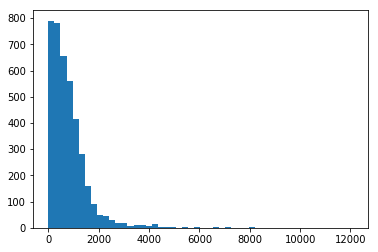

The number of articles greater than 500 in length is:  2336
The number of articles less than 50 in length is:  272


In [163]:
# plot distrubution of artibcles length
plt.hist([len(t) for t in int_text],50)
plt.show()
# print output for nr of articles >500 & <50 in length
print('The number of articles greater than 500 in length is: ', np.sum(np.array([len(t)>500 for t in int_text])))
print('The number of articles less than 50 in length is: ', np.sum(np.array([len(t)<50 for t in int_text])))

#### sequencing / prepadding
We must pass the same lengths of sentences into our model. Therefore we will employ padding in the following way: 
- Sequences less than 500 in length will be prepadded
- Sequences that are longer than 500 will be truncated. 
- We assume sentiment of fake vs real from the first 500 words.



In [164]:
# define pad as len of word2num
num2word[len(word2num)] = '<PAD>'
# add pad as a feature in dict 
word2num['<PAD>'] = len(word2num)

# execute padding as defined above
for i, t in enumerate(int_text):
    # length <500: prepadded  
    if len(t)<500:
        int_text[i] = [word2num['<PAD>']]*(500-len(t)) + t
    # length >500: truncated  
    elif len(t)>500:
        int_text[i] = t[:500]
    else:
        continue

# assign x (text) and y (label) 
x = np.array(int_text)
# fake = 0, real = 1
y = (df_train.label.values=='REAL').astype('int')

# split data into training (80%) and test/validation (20%)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

#### Many to One LSTM

In [168]:
# define model 
model = Sequential()
# add embedding with deimension 
model.add(Embedding(input_dim=len(word2num),
                    output_dim=32))
# add LSTM layer 
model.add(LSTM(100))
# add output layer
model.add(Dense(1, activation='sigmoid'))
# define model compiler 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# define model paramters
batch_size = 64
epochs = 3
# fit model
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          verbose=1)

Train on 3569 samples, validate on 397 samples
Epoch 1/3
3569/3569 [==============================] - 39s 11ms/step - loss: 0.6693 - acc: 0.5901 - val_loss: 0.5587 - val_acc: 0.7078
Epoch 2/3
3569/3569 [==============================] - 35s 10ms/step - loss: 0.5489 - acc: 0.7534 - val_loss: 0.3944 - val_acc: 0.8363
Epoch 3/3
3569/3569 [==============================] - 36s 10ms/step - loss: 0.2432 - acc: 0.9123 - val_loss: 0.3639 - val_acc: 0.8564


#### Model Evaluation

In [170]:
scores = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

397/397 [==============================] - 1s 3ms/step

acc: 85.64%


## Conclusion
In this section we have tried a lot of different approaches using nueral networks of lower and higher complexity. We have also explored other apporaches to text processning such as embedding. The results might not be better than the simpler models covered in section 2, perhaps due to the higher data necessity. The simplest models, sequentional nueral network produced the highest results and thus we'll try using it for our ensamble in the next section.